Importing necessery stuff

In [1]:
import cv2
import random
from PIL import Image
import numpy as np
import math
from matplotlib import pyplot as plt
import time
import json

If this shit aint working, your cuda is probably fucked up

In [2]:
import torch
from torchsummary import summary

Creating dataset

In [ ]:
DATASET_NAME = "Squares_new_2"

Defining NN and creating instance of it

In [32]:
class HuiNet(torch.nn.Module):
    def __init__(self):
        super(HuiNet, self).__init__()
        self.layers_indexes = dict()
        self.conv_lays = [1, 16]
        counter = 0
        self.layers_list = []

        num_convs = 1
        num_fc = 10

        for i in range(num_convs):
            self.layers_list.append(torch.nn.Conv2d(in_channels=self.conv_lays[i], out_channels=self.conv_lays[
                i + 1], kernel_size=16, padding=8, stride=2))
            self.layers_indexes["cv" + str(i + 1)] = counter
            counter += 1
            self.layers_list.append(torch.nn.ReLU())
            self.layers_indexes["act" + str(i + 1)] = counter
            counter += 1
            self.layers_list.append(torch.nn.MaxPool2d(kernel_size=4, stride=4))
            self.layers_indexes["pool" + str(i + 1)] = counter
            counter += 1

        self.layers_list.append(torch.nn.Linear(16*32*32, 100))
        self.layers_indexes['fc1'] = counter
        counter += 1
        self.layers_list.append(torch.nn.ReLU())
        self.layers_indexes[f'act{num_convs + 1}'] = counter
        counter += 1
    
        for i in range(1, num_fc):
            if i == num_fc-1:
                self.layers_list.append(torch.nn.Linear(100, 5))
                self.layers_indexes[f"fc{i+1}"] = counter
                counter += 1
            else:
                self.layers_list.append(torch.nn.Linear(100, 100))
                self.layers_indexes[f"fc{i+1}"] = counter
                counter += 1
                self.layers_list.append(torch.nn.ReLU())
                self.layers_indexes[f"act{i+num_convs + 2}"] = counter
                counter += 1
        self.layers_list = torch.nn.ModuleList(self.layers_list)

    def forward(self, x):
        for key in self.layers_indexes:
            if key == "fc1":
                x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
            x = self.layers_list[self.layers_indexes[key]](x)
        return x


FOLDER_FOR_NETWORKS_EPOCH = "states_28.08.22_try2"

huinet = HuiNet()

start_epoch = 25

if start_epoch != 1:
    huinet.load_state_dict(torch.load(f"States/{FOLDER_FOR_NETWORKS_EPOCH}/state{start_epoch-1}.txt"))
    huinet.eval()
else:
    dictForJson = dict()
    for key in huinet.layers_indexes.keys():
        dictForJson[key] = str(huinet.layers_list[huinet.layers_indexes[key]])
    with open(f"States/{FOLDER_FOR_NETWORKS_EPOCH}/0_model_description", "w") as outfile:
        json.dump(dictForJson, outfile)
        
huinet.float()


HuiNet(
  (layers_list): ModuleList(
    (0): Conv2d(1, 16, kernel_size=(16, 16), stride=(2, 2), padding=(8, 8))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (3): Linear(in_features=16384, out_features=100, bias=True)
    (4): ReLU()
    (5): Linear(in_features=100, out_features=100, bias=True)
    (6): ReLU()
    (7): Linear(in_features=100, out_features=100, bias=True)
    (8): ReLU()
    (9): Linear(in_features=100, out_features=100, bias=True)
    (10): ReLU()
    (11): Linear(in_features=100, out_features=100, bias=True)
    (12): ReLU()
    (13): Linear(in_features=100, out_features=100, bias=True)
    (14): ReLU()
    (15): Linear(in_features=100, out_features=100, bias=True)
    (16): ReLU()
    (17): Linear(in_features=100, out_features=100, bias=True)
    (18): ReLU()
    (19): Linear(in_features=100, out_features=100, bias=True)
    (20): ReLU()
    (21): Linear(in_features=100, out_features=5, bias=True)
  )
)

Custom loss

In [34]:
PARAMS = {
    "dist_loss": 1,
    "size_loss": 1,
    "angle_loss": 1
}

mse_loss = torch.nn.MSELoss()

def my_greatest_loss(target, result, params,tensor_board = None, N = -1, print_state=False):
    global mse_loss

    errs = torch.empty_like(target).to(torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'))
    errs = target - result
    errs /= torch.tensor([255, 255, 255, 255, 180]).to(torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'))
    # errs = torch.nn.functional.normalize(errs)
    loss_dist = (errs[:,0] ** 2 + errs[:,1] ** 2) * params.get("dist_loss")
    loss_size = (errs[:,2] **2 + errs[:,3]**2) * params.get("size_loss")
    loss_angle = errs[:,4] ** 2 * params.get("angle_loss")
    # loss = np.sum(np.linalg.norm(errs.cpu().detach(), axis=0)**2)
    if print_state:
        print(f"Distance loss: {torch.mean(loss_dist)} Size loss: {torch.mean(loss_size)} Angle loss: {torch.mean(loss_angle)}")
    loss_ = loss_dist + loss_size + loss_angle
    if N != -1:
        tensor_board.add_scalar("loss_dist",loss_dist.sum(), N)
        tensor_board.add_scalar("loss_size",loss_size.sum(), N)
        tensor_board.add_scalar("loss_angle",loss_angle.sum(), N)
    del errs
    torch.cuda.empty_cache()
    return loss_.sum()

To GPU if avaliable

In [35]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
huinet = huinet.to(device)
device

device(type='cuda', index=0)

Setting loss and optimizer

In [36]:
# loss = my_greatest_loss
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(huinet.parameters(), lr=1.0e-3)

Getting test dataset

In [37]:
f = open(f"Datasets/{DATASET_NAME}/labels.txt")
f = f.readlines()
N = len(f)
print(N)
N_test = math.floor(0.98 * N)

X_test = torch.zeros((N - N_test, 1, 256, 256))
y_test = torch.zeros(N - N_test, 5)

for i in range(N_test, N):
    name, label = f[i].split()
    label = torch.tensor(list(map(int, label.split("_"))))
    y_test[i - N_test] += label
    img = Image.open(f"Datasets/{DATASET_NAME}/" + name)
    X_test[i - N_test] += torch.tensor(np.asarray(img)).resize(3, 256, 256)[0, :]

50000


Importing torchision for beatiful graphs

In [38]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from itertools import product
from tqdm import tqdm

Learning process. Each epoch is saved 

In [39]:
batch_size = 16
N_epochs = 1000

test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)
tb = SummaryWriter()

norm =  torch.tensor([255, 255, 255, 255, 180]).to(torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'))

for epoch in range(N_epochs):
    order = np.random.permutation(N_test)
    current_losses = []
    time_start = time.time()
    
    for start_index in tqdm(range(0, N_test, batch_size),leave=False):
        torch.cuda.empty_cache()
        X_train = torch.zeros((batch_size,1,256,256))
        y_train = torch.zeros((batch_size,5))
        for i in range(start_index, start_index + batch_size):
            name, label = f[i].split()
            label = torch.tensor(list(map(int, label.split("_"))))
            y_train[i%batch_size] += label
            img = Image.open(f"Datasets/{DATASET_NAME}/" + name)
            X_train[i%batch_size] += torch.tensor(np.asarray(img)).reshape(3, 256, 256)[0, :]
        optimizer.zero_grad()

        X_batch = X_train.to(device)
        y_batch = y_train.to(device)

        preds = huinet.forward(X_batch)

        loss_value = loss(preds/norm, y_batch/norm)
        current_losses.append(loss_value.item())
        loss_value.backward()
        tb.add_scalar("Batch",loss_value.item(), epoch * N_test//batch_size + start_index//batch_size)

        optimizer.step()
        del X_train, y_train, label
        torch.cuda.empty_cache()

    test_preds = huinet.forward(X_test)
    test_loss_history.append(loss(test_preds/norm, y_test/norm).item())
    # # TODO: новая accuracy когда-нибудь
    # # accuracy = (test_preds.argmax(dim=0) == y_test).float().mean().data.cpu()
    accuracy = np.array(current_losses).mean()
    test_accuracy_history.append(accuracy)
    print(f"Epoch: {epoch+start_epoch}/{start_epoch+N_epochs-1} Accuracy: {accuracy} Time:{time.time()-time_start} Last loss: {test_loss_history[-1]}")
    tb.add_scalar("Accuracy",accuracy, epoch)
    del test_preds, accuracy
    torch.cuda.empty_cache()
    torch.save(huinet.state_dict(), f"States/{FOLDER_FOR_NETWORKS_EPOCH}/state{start_epoch + epoch}.txt")

Epoch: 25/1024 Accuracy: 0.020551475399659375 Time:230.36420035362244 Last loss: 0.02702285163104534


KeyboardInterrupt: 










Function that draws picture with desired epoch of neural network

In [84]:
def checkDrawingForEpoche(epoch, drawing, test=True):
    huinet = HuiNet()
    huinet.float()
    huinet.load_state_dict(torch.load(f"States/{FOLDER_FOR_NETWORKS_EPOCH}/state{epoch}.txt"))
    huinet.eval()
    huinet = huinet.to(device)

    k = 171
    a = huinet.forward(X_test[drawing].reshape(1, 1,256,256)).cpu().detach().numpy().astype(dtype=int).reshape(-1).tolist()  #prediction
    b = y_test[drawing].cpu().detach().numpy().astype(dtype=int).tolist()  #label
    print(a,b)

    #original filled with black color
    rect = ((b[0], b[1]), (b[2], b[3]), b[4])
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    whiteblankimage = 255 * np.ones(shape=[256, 256, 3], dtype=np.uint8)
    cv2.drawContours(whiteblankimage,[box],0,(0,0,0),thickness=cv2.FILLED)

    #red contour of prediction
    rect = ((a[0], a[1]), (a[2], a[3]), a[4])
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    cv2.drawContours(whiteblankimage,[box],0,(255,0,0))

    #saving and drawing
    # cv2.imwrite(f'ImagesByEpoch/IM2.0/{drawing}_{epoch}.jpeg' , whiteblankimage)
    plt.imshow(whiteblankimage)
    
def checkDrawingsForEpoche(epoch, drawing, base_img = None, test=True, color=(255,0,0)):
    huinet = HuiNet()
    huinet.float()
    huinet.load_state_dict(torch.load(f"States/{FOLDER_FOR_NETWORKS_EPOCH}/state{epoch}.txt"))
    huinet.eval()
    huinet = huinet.to(device)

    k = 171
    a = huinet.forward(X_test[drawing].reshape(1, 1,256,256)).cpu().detach().numpy().astype(dtype=int).reshape(-1).tolist()  #prediction
    b = y_test[drawing].cpu().detach().numpy().astype(dtype=int).tolist()  #label

    #original filled with black color
    if base_img is None:
        whiteblankimage = 255 * np.ones(shape=[256, 256, 3], dtype=np.uint8)
    else:
        whiteblankimage = base_img

    rect = ((b[0], b[1]), (b[2], b[3]), b[4])
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    cv2.drawContours(whiteblankimage,[box],0,(0,0,0),thickness=cv2.FILLED)

    #red contour of prediction
    rect = ((a[0], a[1]), (a[2], a[3]), a[4])
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    cv2.drawContours(whiteblankimage,[box],0,color)

    #saving and drawing
    # cv2.imwrite(f'ImagesByEpoch/IM2.0/{drawing}_{epoch}.jpeg' , whiteblankimage)
    return whiteblankimage

"... And don't you cry tonight <br>
That's a heaven above you, baby..."

In [ ]:
# for i in range(300):
#     checkDrawingForEpoche(epoch=i, drawing=250)
checkDrawingForEpoche(epoch=24, drawing=100)

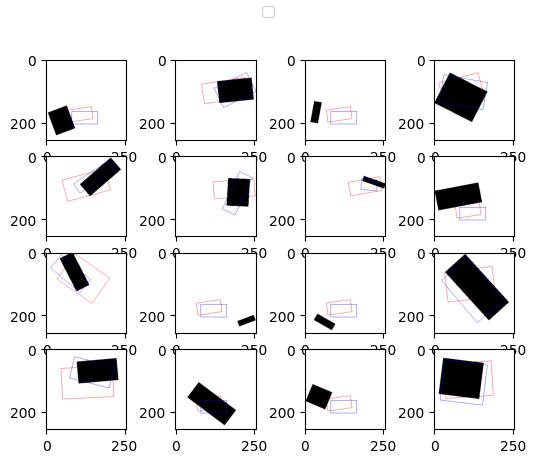

In [102]:
e, d = 25,1
fig, axs = plt.subplots(4,4)

for i in range(4):
    for j in range(4):
        # aa = 0
        result = checkDrawingsForEpoche(epoch = 1, drawing=d + i*4 + j)
        result = checkDrawingsForEpoche(epoch = e, drawing=d + i*4 + j, base_img=result, color=(0,0,255))
        axs[i][j].imshow(result)
str_ = str(f"red - random blue - {e}")
fig.legend(str_, loc='upper center')
plt.show()
        # total = checkDrawingsForEpoche(epoch = 1, drawing=d + i*4 + j) + checkDrawingsForEpoche(epoch = e, drawing=d + i*4 + j, color=(0,0,255))
        # axs[i][j].imshow(checkDrawingsForEpoche(epoch = 1, drawing=d + i*4 + j))
        # axs[i][j].plot(checkDrawingsForEpoche(epoch = 1, drawing=d + i*4 + j))
        # axs[i][j].imshow(checkDrawingsForEpoche(epoch = 1, drawing=d + i*4 + j))
        # axs[i][j].imshow(checkDrawingsForEpoche(epoch = e, drawing=d + i*4 + j, color=(0,0,255)))

# fig, axs = plt.subplots(4,4)
# for i in range(4):
#     for j in range(4):
#         axs[i][j].imshow(checkDrawingsForEpoche(epoch = 1, drawing=d + i*4 + j))


In [ ]:
# b = y_test[3].cpu().detach().numpy().astype(dtype=int).tolist()
# rect = ((b[0], b[1]), (b[2], b[3]), b[4])
# box = cv2.boxPoints(rect)
# box = np.int0(box)
# whiteblankimage = 255 * np.ones(shape=[256, 256, 3], dtype=np.uint8)
# cv2.drawContours(whiteblankimage,[box],0,(0,0,0),thickness=cv2.FILLED)
huinet = HuiNet()
huinet.float()
huinet.load_state_dict(torch.load(f"states_3.1.1/state{54}.txt"))
huinet.eval()
huinet = huinet.to(device)
whitenoise = torch.tensor(np.random.randint(0,255,(256,256)),dtype=torch.float32)
whitenoise = whitenoise.to(device)

huinet.layers_list[0].reset_parameters()

im =  huinet.layers_list[0](whitenoise.reshape(1, 1,256,256)).cpu().detach().numpy().astype(dtype=int).reshape(16,129,129)
# im = huinet.layers_list[1](im)
# im = huinet.layers_list[2](im)
# plt.imshow(im[7])
# print(im[5])

fig, axs = plt.subplots(4,4)
for i in range(4):
    for j in range(4):
        axs[i][j].imshow(im[i*4+j],cmap="gray",vmin=0,vmax=255)
        axs[i][j].set_axis_off()

In [ ]:
plt.imshow(whitenoise.cpu().numpy(),cmap="gray", vmin=0,vmax=255)